# Get My PlayList

In [134]:
import pandas
import requests
import json

In [135]:
TOKEN = "BQAfI7IC-g8hFCn0GuD76YrxHfCK5Lm4oX1UOuwkSmmmDZcJ24ChQa6eCWmtfsa7zIwCJAILKsuMwPGiNsSntzzY4WtDuT-lpt7vHynvXJlJF3_Z5IGknpg6aVoHGnqmmsy-oT-E6dkh8SGrr5yn6erVm8JtkiPw0SA" 

In [136]:
def get_playlist_tracks(playlist_id, sample, TOKEN):
    """
    Returns a list of tracks from a playlist
    """
    url = "https://api.spotify.com/v1/playlists/"+playlist_id
    headers = {"Accept": "application/json", "Content-Type": "application/json" ,'Authorization': "Bearer {}".format(TOKEN)}
    r = requests.get(url, headers=headers)
    r = r.json()

    response_df = pandas.json_normalize(r['tracks']["items"])
    response_df.shape

    requested_tracks = ""

    for i in response_df.sample(sample)['track.id'].to_list():
        requested_tracks += i + ","

    return requested_tracks

In [137]:
def get_audio_features(track_id_list, TOKEN):
    """
    Returns a list of audio features for a list of tracks
    """

    url = "https://api.spotify.com/v1/audio-features/?ids=" + track_id_list
    headers = {"Accept": "application/json", "Content-Type": "application/json" ,'Authorization': "Bearer {}".format(TOKEN)}
    r = requests.get(url, headers=headers)
    r = r.json()
    response_df = pandas.json_normalize(r['audio_features'])
    return response_df

In [138]:
# number tracks to get
sample = 36

# playlist id
playlist_id = "5xDI2Pj1Hlut9L4lZIz0Jr"

# get tracks from playlist
req_tracks = get_playlist_tracks(playlist_id, sample, TOKEN)
# get audio features for tracks
mix = get_audio_features(req_tracks, TOKEN)

KeyError: ignored

In [ ]:
mix.head()

# Read Data

In [326]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import random
from google.colab import drive
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import LabelEncoder

In [327]:
!ls

drive  model.pkl  sample_data


In [328]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [329]:
data = pd.read_csv('/content/drive/MyDrive/genres_v2.csv')
data.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


danceability  energy  ...  Unnamed: 0  title
0         0.831   0.814  ...         NaN    NaN
1         0.719   0.493  ...         NaN    NaN
2         0.850   0.893  ...         NaN    NaN
3         0.476   0.781  ...         NaN    NaN
4         0.798   0.624  ...         NaN    NaN

[5 rows x 22 columns]

# PreProcessing

In [330]:
data.shape

(42305, 22)

In [331]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42305 entries, 0 to 42304
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      42305 non-null  float64
 1   energy            42305 non-null  float64
 2   key               42305 non-null  int64  
 3   loudness          42305 non-null  float64
 4   mode              42305 non-null  int64  
 5   speechiness       42305 non-null  float64
 6   acousticness      42305 non-null  float64
 7   instrumentalness  42305 non-null  float64
 8   liveness          42305 non-null  float64
 9   valence           42305 non-null  float64
 10  tempo             42305 non-null  float64
 11  type              42305 non-null  object 
 12  id                42305 non-null  object 
 13  uri               42305 non-null  object 
 14  track_href        42305 non-null  object 
 15  analysis_url      42305 non-null  object 
 16  duration_ms       42305 non-null  int64 

In [332]:
data.isna().sum()

danceability            0
energy                  0
key                     0
loudness                0
mode                    0
speechiness             0
acousticness            0
instrumentalness        0
liveness                0
valence                 0
tempo                   0
type                    0
id                      0
uri                     0
track_href              0
analysis_url            0
duration_ms             0
time_signature          0
genre                   0
song_name           20786
Unnamed: 0          21525
title               21525
dtype: int64

In [333]:
data.drop(columns=['song_name' , 'Unnamed: 0' , 'title','type','id','uri','track_href','analysis_url','time_signature','mode'], inplace=True)
data.head()

danceability  energy  key  ...    tempo  duration_ms      genre
0         0.831   0.814    2  ...  156.985       124539  Dark Trap
1         0.719   0.493    8  ...  115.080       224427  Dark Trap
2         0.850   0.893    5  ...  218.050        98821  Dark Trap
3         0.476   0.781    0  ...  186.948       123661  Dark Trap
4         0.798   0.624    2  ...  147.988       123298  Dark Trap

[5 rows x 12 columns]

In [334]:
data.isna().sum()

danceability        0
energy              0
key                 0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
genre               0
dtype: int64

In [335]:
data.describe()

danceability        energy  ...         tempo    duration_ms
count  42305.000000  42305.000000  ...  42305.000000   42305.000000
mean       0.639364      0.762516  ...    147.474056  250865.846685
std        0.156617      0.183823  ...     23.844623  102957.713571
min        0.065100      0.000243  ...     57.967000   25600.000000
25%        0.524000      0.632000  ...    129.931000  179840.000000
50%        0.646000      0.803000  ...    144.973000  224760.000000
75%        0.766000      0.923000  ...    161.464000  301133.000000
max        0.988000      1.000000  ...    220.290000  913052.000000

[8 rows x 11 columns]

In [336]:
data.head()

danceability  energy  key  ...    tempo  duration_ms      genre
0         0.831   0.814    2  ...  156.985       124539  Dark Trap
1         0.719   0.493    8  ...  115.080       224427  Dark Trap
2         0.850   0.893    5  ...  218.050        98821  Dark Trap
3         0.476   0.781    0  ...  186.948       123661  Dark Trap
4         0.798   0.624    2  ...  147.988       123298  Dark Trap

[5 rows x 12 columns]

In [337]:
for col in data.columns :
  if data[col].dtype == 'int64' or data[col].dtype == 'float64':
    up = data[col].mean() + 3*data[col].std()
    low = data[col].mean() - 3*data[col].std()
    mask = (data[col] > up ) | (data[col] < low )
    data = data.drop(data[mask].index)

In [338]:
data['index'] = list(range(len(data)))
data.set_index(data['index'], inplace = True)
data.drop(columns='index',inplace=True)

In [339]:
genre = data['genre']
genre

index
0        Dark Trap
1        Dark Trap
2        Dark Trap
3        Dark Trap
4        Dark Trap
           ...    
38898    hardstyle
38899    hardstyle
38900    hardstyle
38901    hardstyle
38902    hardstyle
Name: genre, Length: 38903, dtype: object

In [340]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data.drop(columns='genre'))
data_scaled

array([[0.80736196, 0.76245211, 0.18181818, ..., 0.38202827, 0.5683183 ,
        0.14858938],
       [0.66993865, 0.35249042, 0.72727273, ..., 0.1086351 , 0.27296307,
        0.34277894],
       [0.83067485, 0.8633461 , 0.45454545, ..., 0.02104612, 0.99871723,
        0.09859171],
       ...,
       [0.23067485, 0.77139208, 0.72727273, ..., 0.1086351 , 0.55386947,
        0.36298952],
       [0.37300613, 0.899106  , 0.54545455, ..., 0.48416383, 0.51938258,
        0.53480085],
       [0.43680982, 0.92975734, 0.81818182, ..., 0.11895182, 0.55465887,
        0.22172929]])

In [341]:
# data_scaled = normalize(data.drop(columns='genre'))
# data_scaled = pd.DataFrame(data_scaled, columns=data.drop(columns='genre').columns)
# data_scaled.head()

In [342]:
data = pd.DataFrame(data_scaled,index= data.index,columns=data.drop(columns='genre').columns)
data.head()

danceability    energy       key  ...   valence     tempo  duration_ms
index                                    ...                                 
0          0.807362  0.762452  0.181818  ...  0.382028  0.568318     0.148589
1          0.669939  0.352490  0.727273  ...  0.108635  0.272963     0.342779
2          0.830675  0.863346  0.454545  ...  0.021046  0.998717     0.098592
3          0.371779  0.720307  0.000000  ...  0.161250  0.779504     0.146882
4          0.766871  0.519796  0.181818  ...  0.590426  0.504906     0.146177

[5 rows x 11 columns]

In [343]:
data['genre'] = genre

In [344]:
data.head()

danceability    energy       key  ...     tempo  duration_ms      genre
index                                    ...                                  
0          0.807362  0.762452  0.181818  ...  0.568318     0.148589  Dark Trap
1          0.669939  0.352490  0.727273  ...  0.272963     0.342779  Dark Trap
2          0.830675  0.863346  0.454545  ...  0.998717     0.098592  Dark Trap
3          0.371779  0.720307  0.000000  ...  0.779504     0.146882  Dark Trap
4          0.766871  0.519796  0.181818  ...  0.504906     0.146177  Dark Trap

[5 rows x 12 columns]

In [345]:
len(data)

38903

# One-hot Encoding

In [230]:
pd.get_dummies(data['genre'])

Dark Trap  Emo  Hiphop  Pop  ...  techhouse  techno  trance  trap
index                               ...                                 
0              1    0       0    0  ...          0       0       0     0
1              1    0       0    0  ...          0       0       0     0
2              1    0       0    0  ...          0       0       0     0
3              1    0       0    0  ...          0       0       0     0
4              1    0       0    0  ...          0       0       0     0
...          ...  ...     ...  ...  ...        ...     ...     ...   ...
38898          0    0       0    0  ...          0       0       0     0
38899          0    0       0    0  ...          0       0       0     0
38900          0    0       0    0  ...          0       0       0     0
38901          0    0       0    0  ...          0       0       0     0
38902          0    0       0    0  ...          0       0       0     0

[38903 rows x 15 columns]

In [231]:
data = pd.concat([data, pd.get_dummies(data['genre'])], axis=1)

In [232]:
data.drop(columns='genre',inplace=True)
data.head()

danceability    energy       key  ...  techno  trance  trap
index                                    ...                      
0          0.807362  0.762452  0.181818  ...       0       0     0
1          0.669939  0.352490  0.727273  ...       0       0     0
2          0.830675  0.863346  0.454545  ...       0       0     0
3          0.371779  0.720307  0.000000  ...       0       0     0
4          0.766871  0.519796  0.181818  ...       0       0     0

[5 rows x 26 columns]

In [233]:
data.describe()

danceability        energy  ...        trance          trap
count  38903.000000  38903.000000  ...  38903.000000  38903.000000
mean       0.575577      0.711739  ...      0.072411      0.071177
std        0.190737      0.218243  ...      0.259170      0.257124
min        0.000000      0.000000  ...      0.000000      0.000000
25%        0.434356      0.550447  ...      0.000000      0.000000
50%        0.582822      0.759898  ...      0.000000      0.000000
75%        0.731288      0.902937  ...      0.000000      0.000000
max        1.000000      1.000000  ...      1.000000      1.000000

[8 rows x 26 columns]

# Kmeans

In [183]:
from sklearn import metrics

In [184]:
inertia_list = []
silhouette_list = []
for k in np.arange(2, 25):
  kmn = KMeans(n_clusters=k)
  kmn.fit(data)
  y_clusters = kmn.fit_predict(data)
  silhouette_list.append(metrics.silhouette_score(data,y_clusters))
  inertia_list.append(kmn.inertia_)

In [185]:
arr = []
arr2 = []
count = 0
for item in inertia_list:
  if count % 5 ==0:
    arr.append(item)
    arr2.append(count)
  count = count + 1
arr

[51968.12073836518,
 33799.43460154859,
 20465.392267705305,
 15606.393096565189,
 14000.566231227782]

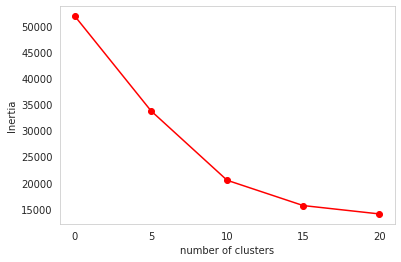

In [186]:
plt.plot(arr2,arr,'ro-')
plt.xticks(ticks=arr2)
plt.xlabel('number of clusters')
plt.ylabel('Inertia')
plt.show()

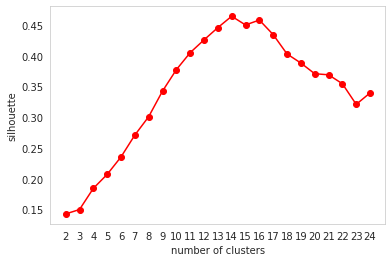

In [187]:
plt.plot(np.arange(2, 25),silhouette_list,'ro-')
plt.xticks(ticks=np.arange(2, 25))
plt.xlabel('number of clusters')
plt.ylabel('silhouette')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


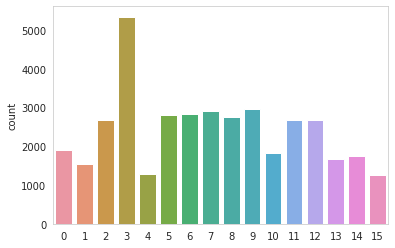

In [188]:
kmn = KMeans(n_clusters = 16, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
y_clusters = kmn.fit_predict(data)
# countplot to check the number of clusters and number of customers in each cluster
sb.countplot(y_clusters)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


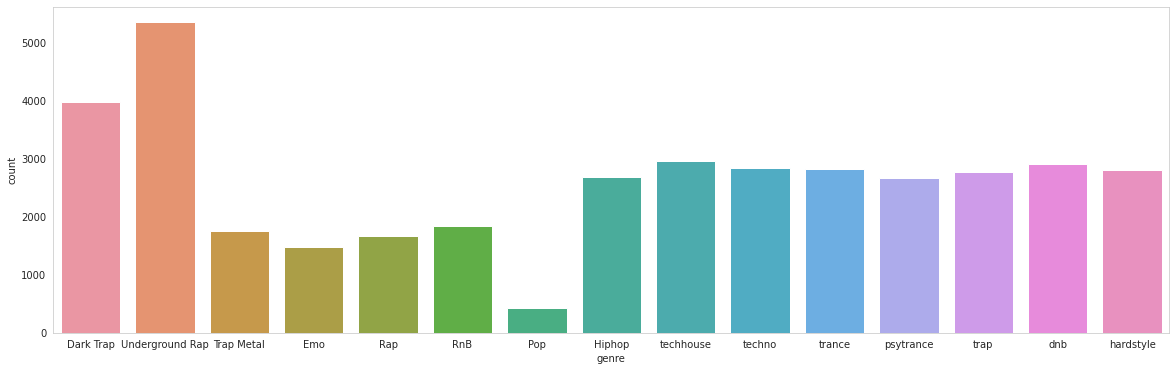

In [189]:
fig = plt.figure(figsize=(20,6))
sb.countplot(genre)

In [190]:
from sklearn import metrics
print(metrics.silhouette_score(data, y_clusters))

0.4360834755683112


In [191]:
data['cluster'] = y_clusters
data['genre'] = genre
for gen in list(data['genre'].unique()):
  print(f'genre : {gen}')
  print('cluster :',data[data['genre']==gen]['cluster'].unique())
data.drop(columns=['genre','cluster'],inplace=True)

genre : Dark Trap
cluster : [11  4]
genre : Underground Rap
cluster : [3]
genre : Trap Metal
cluster : [14]
genre : Emo
cluster : [0]
genre : Rap
cluster : [13]
genre : RnB
cluster : [10]
genre : Pop
cluster : [0 4]
genre : Hiphop
cluster : [2]
genre : techhouse
cluster : [9]
genre : techno
cluster : [6]
genre : trance
cluster : [15  1]
genre : psytrance
cluster : [12]
genre : trap
cluster : [8]
genre : dnb
cluster : [7]
genre : hardstyle
cluster : [5]


In [196]:
pca = PCA(n_components = 3)
X = pca.fit_transform(data)
X=pd.DataFrame(X)

In [197]:
X.head()

0         1         2
0  0.456523 -0.073089  0.795457
1  0.298205  0.060118  0.801672
2  0.208557 -0.316825  0.690392
3  0.254301 -0.348495  0.950441
4  0.527425  0.004430  0.860471

In [198]:
X['cluster'] = y_clusters

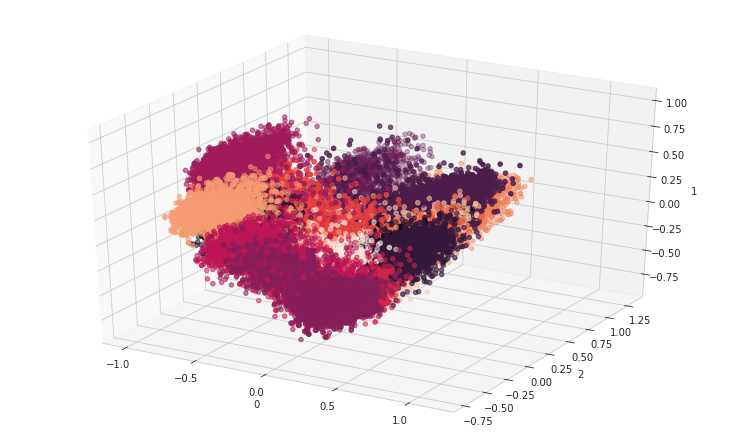

In [199]:
sb.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(10,6))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2

x = X[0]
y = X[2]
z = X[1]


ax.scatter(x, y, z, c=y_clusters, marker='o')
ax.set_xlabel('0')
ax.set_ylabel('2')
ax.set_zlabel('1')

plt.show()

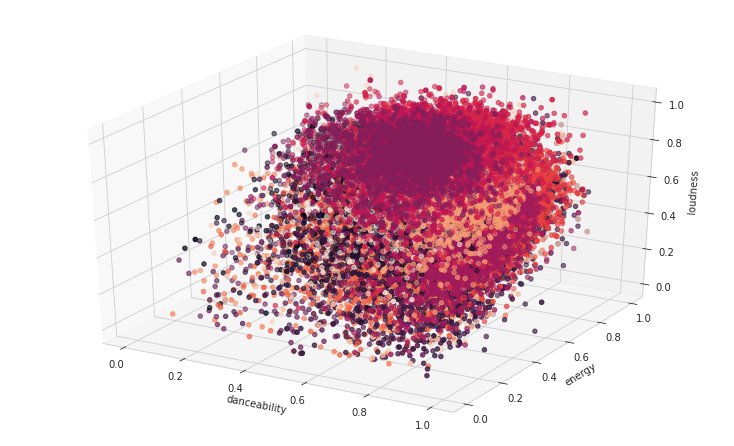

In [200]:
sb.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(10,6))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2

x = data['danceability']
y = data['energy']
z = data['loudness']


ax.scatter(x, y, z, c=X['cluster'], marker='o')
ax.set_xlabel('danceability')
ax.set_ylabel('energy')
ax.set_zlabel('loudness')

plt.show()

In [201]:
pca = PCA(n_components = 2)
X = pca.fit_transform(data)
X=pd.DataFrame(X)
X['cluster'] = y_clusters
data['cluster'] = y_clusters

In [202]:
X.head()

0         1  cluster
0  0.456566 -0.073223       11
1  0.298212  0.060096       11
2  0.208575 -0.316218       11
3  0.254303 -0.347855       11
4  0.527396  0.004401       11

In [203]:
data.head()

danceability    energy       key  ...  trance  trap  cluster
index                                    ...                       
0          0.807362  0.762452  0.181818  ...       0     0       11
1          0.669939  0.352490  0.727273  ...       0     0       11
2          0.830675  0.863346  0.454545  ...       0     0       11
3          0.371779  0.720307  0.000000  ...       0     0       11
4          0.766871  0.519796  0.181818  ...       0     0       11

[5 rows x 27 columns]

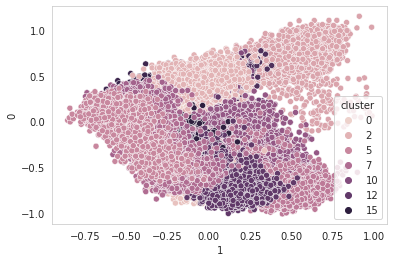

In [204]:
sb.scatterplot(data=X, x=1, y=0, hue="cluster")

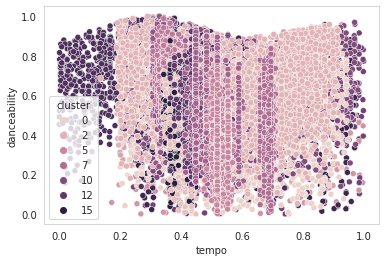

In [205]:
sb.scatterplot(data=data, x='tempo', y='danceability', hue="cluster")

# hierarchical clustering

In [235]:
# data.drop(columns='cluster',inplace=True)
data.head()

danceability    energy       key  ...  techno  trance  trap
index                                    ...                      
0          0.807362  0.762452  0.181818  ...       0       0     0
1          0.669939  0.352490  0.727273  ...       0       0     0
2          0.830675  0.863346  0.454545  ...       0       0     0
3          0.371779  0.720307  0.000000  ...       0       0     0
4          0.766871  0.519796  0.181818  ...       0       0     0

[5 rows x 26 columns]

In [236]:
pca = PCA(n_components = 3)
X = pca.fit_transform(data)
X=pd.DataFrame(X)
X.head()

0         1         2
0  0.456647 -0.076043  0.806844
1  0.298297  0.063685  0.801797
2  0.208252 -0.321909  0.692230
3  0.254167 -0.351096  0.952157
4  0.527449  0.000897  0.866124

In [208]:
# import scipy.cluster.hierarchy as shc
# plt.figure(figsize=(10, 7))  
# plt.title("Dendrograms")  
# dend = shc.dendrogram(shc.linkage(X, method='single'))

In [237]:
# silhouette_list = []
# for k in np.arange(2, 25):
#   cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='single')  
#   cluster.fit(data)
#   silhouette_list.append(metrics.silhouette_score(data,cluster.labels_))

In [ ]:
plt.plot(np.arange(2, 25),silhouette_list,'ro-')
plt.xticks(ticks=np.arange(2, 25))
plt.xlabel('number of clusters')
plt.ylabel('Inertia')
plt.show()

In [238]:
cluster = AgglomerativeClustering(n_clusters=15, affinity='euclidean', linkage='single')  
cluster.fit_predict(data)

array([6, 6, 6, ..., 7, 7, 7])

In [239]:
from sklearn import metrics
print(metrics.silhouette_score(data, cluster.labels_))

0.472671818508472


In [240]:
data['cluster'] = cluster.labels_
data['genre'] = genre
for gen in list(data['genre'].unique()):
  print(f'genre : {gen}')
  print('cluster :',data[data['genre']==gen]['cluster'].unique())
data.drop(columns=['genre','cluster'],inplace=True)

genre : Dark Trap
cluster : [6]
genre : Underground Rap
cluster : [4]
genre : Trap Metal
cluster : [14]
genre : Emo
cluster : [5]
genre : Rap
cluster : [2]
genre : RnB
cluster : [10]
genre : Pop
cluster : [0]
genre : Hiphop
cluster : [3]
genre : techhouse
cluster : [8]
genre : techno
cluster : [13]
genre : trance
cluster : [12]
genre : psytrance
cluster : [1]
genre : trap
cluster : [9]
genre : dnb
cluster : [11]
genre : hardstyle
cluster : [7]


In [241]:
pca = PCA(n_components = 2)
X = pca.fit_transform(data)
X=pd.DataFrame(X)
X.head()

0         1
0  0.456568 -0.073373
1  0.298212  0.060147
2  0.208577 -0.316298
3  0.254305 -0.348076
4  0.527398  0.004284

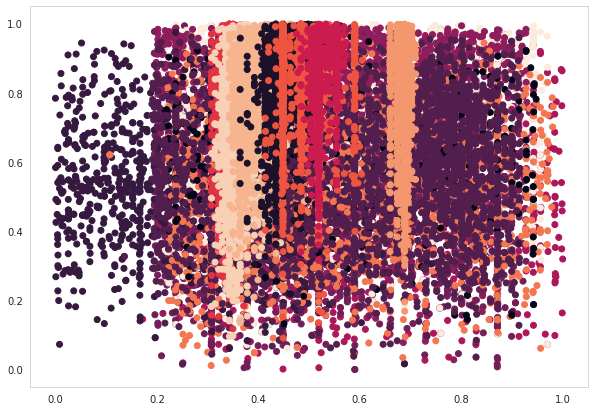

In [242]:
plt.figure(figsize=(10, 7))  
plt.scatter(data['tempo'], data['energy'], c=cluster.labels_) 

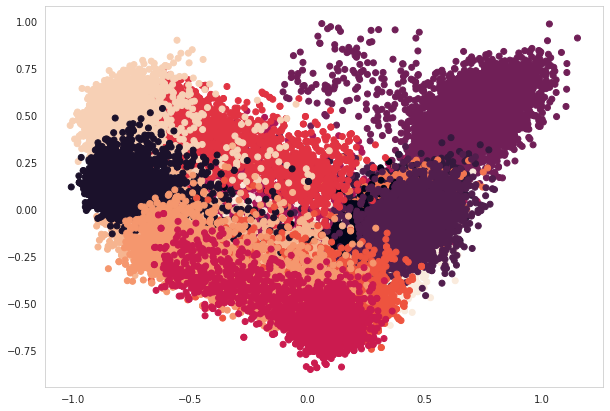

In [243]:
plt.figure(figsize=(10, 7))  
plt.scatter(X[0], X[1], c=cluster.labels_) 

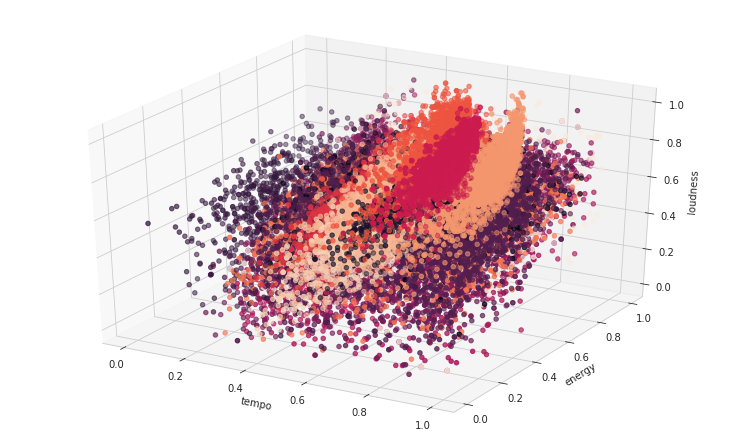

In [244]:
sb.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(10,6))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2

x = data['tempo']
y = data['energy']
z = data['loudness']


ax.scatter(x, y, z, c=cluster.labels_, marker='o')
ax.set_xlabel('tempo')
ax.set_ylabel('energy')
ax.set_zlabel('loudness')

plt.show()

In [245]:
pca = PCA(n_components = 3)
X = pca.fit_transform(data)
X=pd.DataFrame(X)

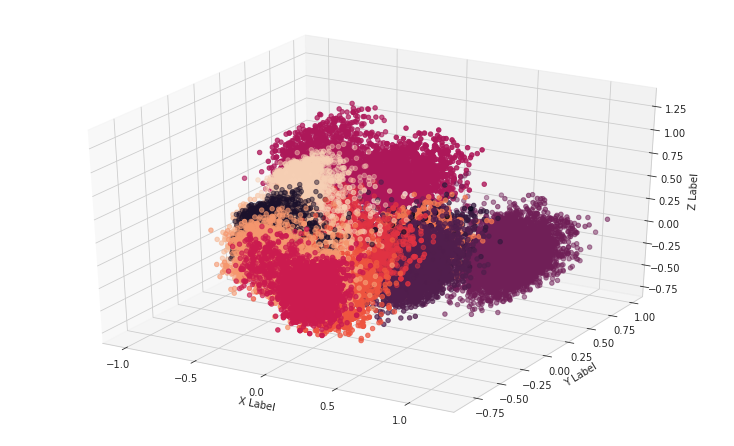

In [246]:
sb.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(10,6))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2

x = X[0]
y = X[1]
z = X[2]


ax.scatter(x, y, z, c=cluster.labels_, marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

# DBSCAN

In [247]:
data.head()

danceability    energy       key  ...  techno  trance  trap
index                                    ...                      
0          0.807362  0.762452  0.181818  ...       0       0     0
1          0.669939  0.352490  0.727273  ...       0       0     0
2          0.830675  0.863346  0.454545  ...       0       0     0
3          0.371779  0.720307  0.000000  ...       0       0     0
4          0.766871  0.519796  0.181818  ...       0       0     0

[5 rows x 26 columns]

In [248]:
cluster = DBSCAN(eps=0.5, min_samples=5).fit(data)
cluster.fit_predict(data)

array([ 0,  0, -1, ..., 17, 17, 17])

In [249]:
from sklearn import metrics
print(metrics.silhouette_score(data, cluster.labels_))

0.40092465291031937


In [250]:
pd.DataFrame(cluster.labels_).value_counts()

 1     5297
 0     3913
 11    2937
 16    2892
 12    2823
 17    2803
 13    2803
 15    2755
 14    2662
 9     2624
 7     1809
 3     1642
 5     1625
 4     1449
-1      444
 8      409
 10       6
 2        5
 6        5
dtype: int64

In [251]:
data['cluster'] = cluster.labels_
data['genre'] = genre
for gen in list(data['genre'].unique()):
  print(f'genre : {gen}')
  print('cluster :',data[data['genre']==gen]['cluster'].unique())
data.drop(columns=['genre','cluster'],inplace=True)

genre : Dark Trap
cluster : [ 0 -1]
genre : Underground Rap
cluster : [ 1 -1  2]
genre : Trap Metal
cluster : [ 3 -1]
genre : Emo
cluster : [ 4 -1]
genre : Rap
cluster : [ 5 -1  6]
genre : RnB
cluster : [ 7 -1]
genre : Pop
cluster : [ 8 -1]
genre : Hiphop
cluster : [ 9 -1 10]
genre : techhouse
cluster : [11 -1]
genre : techno
cluster : [12 -1]
genre : trance
cluster : [13 -1]
genre : psytrance
cluster : [14 -1]
genre : trap
cluster : [15 -1]
genre : dnb
cluster : [16 -1]
genre : hardstyle
cluster : [17 -1]


In [252]:
pca = PCA(n_components = 2)
X = pca.fit_transform(data)
X=pd.DataFrame(X)

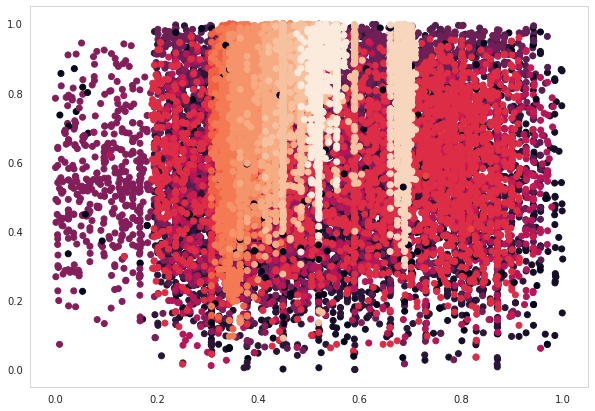

In [253]:
plt.figure(figsize=(10, 7))  
plt.scatter(data['tempo'], data['energy'], c=cluster.labels_) 

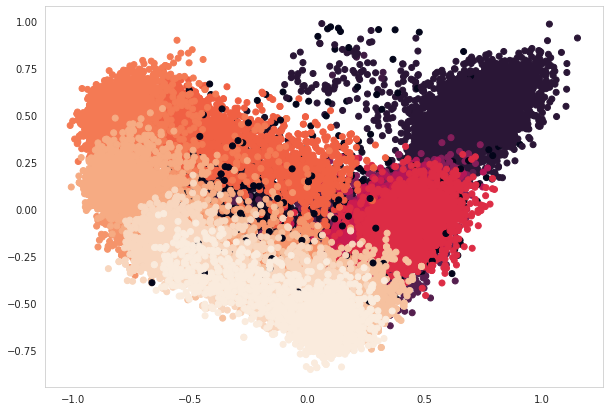

In [254]:
plt.figure(figsize=(10, 7))  
plt.scatter(X[0], X[1], c=cluster.labels_) 

In [255]:
pca = PCA(n_components = 3)
X = pca.fit_transform(data)
X=pd.DataFrame(X)

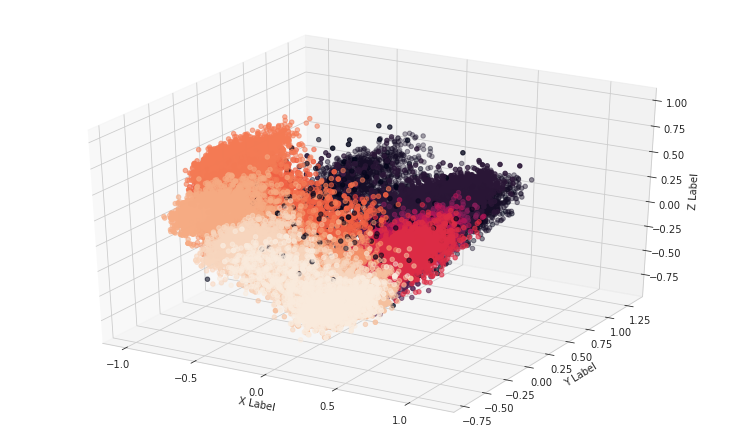

In [256]:
sb.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(10,6))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2

x = X[0]
y = X[2]
z = X[1]


ax.scatter(x, y, z, c=cluster.labels_, marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

# Label_Encoding

In [346]:
data = pd.read_csv('/content/drive/MyDrive/genres_v2.csv')
data.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


danceability  energy  ...  Unnamed: 0  title
0         0.831   0.814  ...         NaN    NaN
1         0.719   0.493  ...         NaN    NaN
2         0.850   0.893  ...         NaN    NaN
3         0.476   0.781  ...         NaN    NaN
4         0.798   0.624  ...         NaN    NaN

[5 rows x 22 columns]

In [347]:
data.drop(columns=['song_name' , 'Unnamed: 0' , 'title','type','id','uri','track_href','analysis_url','time_signature','mode'], inplace=True)
data.head()

danceability  energy  key  ...    tempo  duration_ms      genre
0         0.831   0.814    2  ...  156.985       124539  Dark Trap
1         0.719   0.493    8  ...  115.080       224427  Dark Trap
2         0.850   0.893    5  ...  218.050        98821  Dark Trap
3         0.476   0.781    0  ...  186.948       123661  Dark Trap
4         0.798   0.624    2  ...  147.988       123298  Dark Trap

[5 rows x 12 columns]

In [348]:
for col in data.columns :
  if data[col].dtype == 'int64' or data[col].dtype == 'float64':
    up = data[col].mean() + 3*data[col].std()
    low = data[col].mean() - 3*data[col].std()
    mask = (data[col] > up ) | (data[col] < low )
    data = data.drop(data[mask].index)

In [349]:
data['index'] = list(range(len(data)))
data.set_index(data['index'], inplace = True)
data.drop(columns='index',inplace=True)

In [350]:
len(data)

38903

In [351]:
data['genre'].unique()

array(['Dark Trap', 'Underground Rap', 'Trap Metal', 'Emo', 'Rap', 'RnB',
       'Pop', 'Hiphop', 'techhouse', 'techno', 'trance', 'psytrance',
       'trap', 'dnb', 'hardstyle'], dtype=object)

In [352]:
label_encoder = LabelEncoder()
 
data['genre']= label_encoder.fit_transform(data['genre'])
 
data['genre'].unique()

array([ 0,  7,  6,  1,  4,  5,  3,  2, 11, 12, 13, 10, 14,  8,  9])

In [353]:
data.head()

danceability  energy  key  ...    tempo  duration_ms  genre
index                             ...                             
0             0.831   0.814    2  ...  156.985       124539      0
1             0.719   0.493    8  ...  115.080       224427      0
2             0.850   0.893    5  ...  218.050        98821      0
3             0.476   0.781    0  ...  186.948       123661      0
4             0.798   0.624    2  ...  147.988       123298      0

[5 rows x 12 columns]

In [354]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data)
len(data_scaled[1])

12

In [281]:
# data_scaled = normalize(data)
# data_scaled = pd.DataFrame(data_scaled, columns=data.columns)
# data_scaled.head()

In [355]:
data = pd.DataFrame(data_scaled,index= data.index,columns=data.columns)
data.head()

danceability    energy       key  ...     tempo  duration_ms  genre
index                                    ...                              
0          0.807362  0.762452  0.181818  ...  0.568318     0.148589    0.0
1          0.669939  0.352490  0.727273  ...  0.272963     0.342779    0.0
2          0.830675  0.863346  0.454545  ...  0.998717     0.098592    0.0
3          0.371779  0.720307  0.000000  ...  0.779504     0.146882    0.0
4          0.766871  0.519796  0.181818  ...  0.504906     0.146177    0.0

[5 rows x 12 columns]

# Kmeans

In [357]:
inertia_list = []
silhouette_list = []
for k in np.arange(2, 25):
  kmn = KMeans(n_clusters=k)
  kmn.fit(data)
  y_clusters = kmn.fit_predict(data)
  silhouette_list.append(metrics.silhouette_score(data,y_clusters))
  inertia_list.append(kmn.inertia_)

In [358]:
arr = []
arr2 = []
count = 0
for item in inertia_list:
  if count % 5 ==0:
    arr.append(item)
    arr2.append(count)
  count = count + 1
arr

[20805.52099840608,
 14189.80570920628,
 11973.691799491433,
 10803.943265964139,
 10037.662920584786]

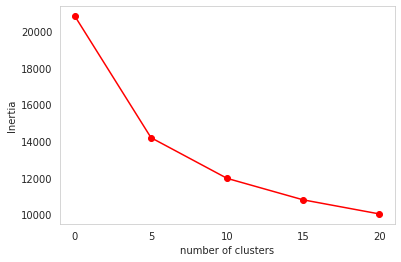

In [359]:
plt.plot(arr2,arr,'ro-')
plt.xticks(ticks=arr2)
plt.xlabel('number of clusters')
plt.ylabel('Inertia')
plt.show()

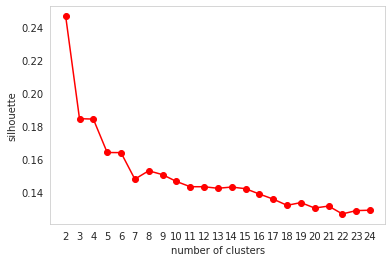

In [360]:
plt.plot(np.arange(2, 25),silhouette_list,'ro-')
plt.xticks(ticks=np.arange(2, 25))
plt.xlabel('number of clusters')
plt.ylabel('silhouette')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


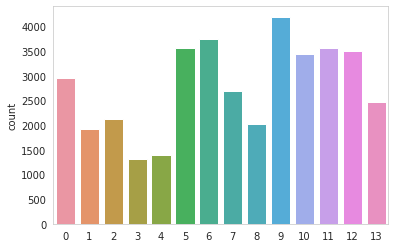

In [361]:
kmn = KMeans(n_clusters = 14, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
y_clusters = kmn.fit_predict(data)
# countplot to check the number of clusters and number of customers in each cluster
sb.countplot(y_clusters)

In [362]:
from sklearn import metrics
print(metrics.silhouette_score(data, y_clusters))

0.14215818424087023


In [363]:
data['cluster'] = y_clusters
data['genre1'] = genre

In [364]:
for gen in list(data['genre1'].unique()):
  print(f'genre : {gen}')
  print('cluster :',data[data['genre1']==gen]['cluster'].unique())

genre : Dark Trap
cluster : [ 7  2 10  0  6 13  3  8  1]
genre : Underground Rap
cluster : [ 7 13  6  0 10  2 11  5  4  9 12  8  3  1]
genre : Trap Metal
cluster : [13  0  6 12 11  2  7  4 10  3  5  1  8  9]
genre : Emo
cluster : [10 13  0  2  6  7  3  1]
genre : Rap
cluster : [ 0  6 10  2  7 13  3 12  5  4]
genre : RnB
cluster : [10  2  7 13  6  0 11 12  3  8  5  4]
genre : Pop
cluster : [10 13  2  7  0  6  3]
genre : Hiphop
cluster : [ 6  7 13 10  2  0  3]
genre : techhouse
cluster : [ 8  9  5 11 12 13  1  6  4  0 10  7  2]
genre : techno
cluster : [ 1  9  5 11  8 12  0  6  4  2]
genre : trance
cluster : [11  5  1 12  8  9  2  4]
genre : psytrance
cluster : [ 1  5  9  8  4 11  0 12  7]
genre : trap
cluster : [12  5 11  4  8  9  1  0  7  6  2]
genre : dnb
cluster : [ 9  5  8 11  4 12 13  1  6  2  7  0 10]
genre : hardstyle
cluster : [12  4 11  9  8 13  5  1  0  2  6  7]


In [365]:
data.drop(columns=['genre1','cluster'],inplace=True)

In [366]:
pca = PCA(n_components = 3)
X = pca.fit_transform(data)
X=pd.DataFrame(X)

In [367]:
X.head()

0         1         2
0 -0.693851 -0.233400  0.124018
1 -0.561621  0.293738  0.517798
2 -0.447019 -0.023683 -0.032075
3 -0.505145 -0.463227  0.063378
4 -0.782531 -0.206600  0.277723

In [368]:
X['cluster'] = y_clusters

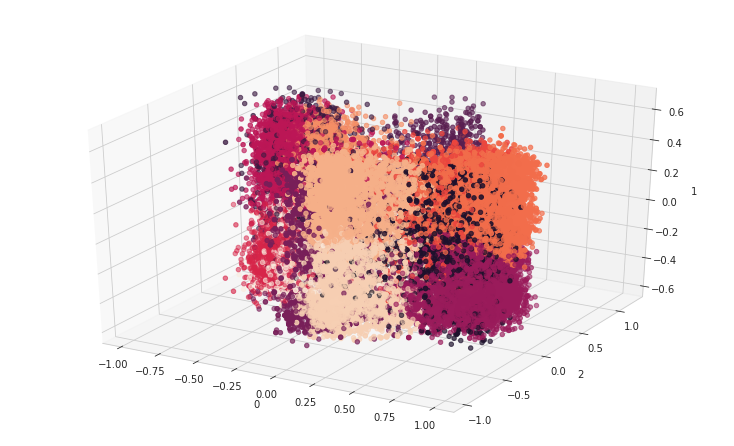

In [369]:
sb.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(10,6))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2

x = X[0]
y = X[2]
z = X[1]


ax.scatter(x, y, z, c=X['cluster'], marker='o')
ax.set_xlabel('0')
ax.set_ylabel('2')
ax.set_zlabel('1')

plt.show()

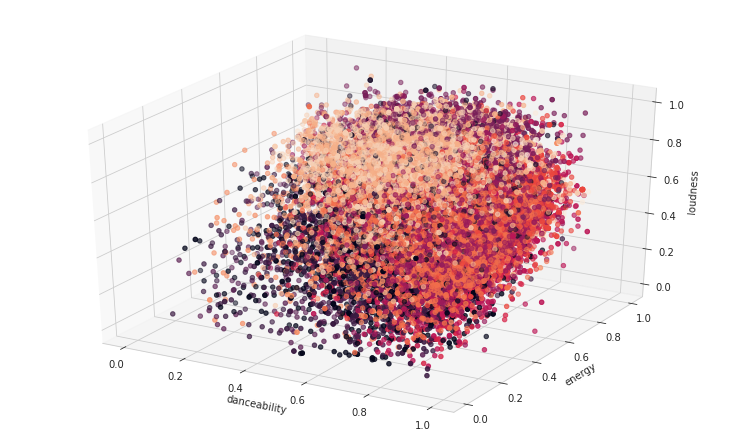

In [370]:
sb.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(10,6))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2

x = data['danceability']
y = data['energy']
z = data['loudness']


ax.scatter(x, y, z, c=X['cluster'], marker='o')
ax.set_xlabel('danceability')
ax.set_ylabel('energy')
ax.set_zlabel('loudness')

plt.show()

In [371]:
pca = PCA(n_components = 2)
X = pca.fit_transform(data)
X=pd.DataFrame(X)
X['cluster'] = y_clusters
data['cluster'] = y_clusters

In [372]:
X.head()

0         1  cluster
0 -0.693851 -0.233400        7
1 -0.561621  0.293738        2
2 -0.447019 -0.023683       10
3 -0.505145 -0.463227        0
4 -0.782531 -0.206600        7

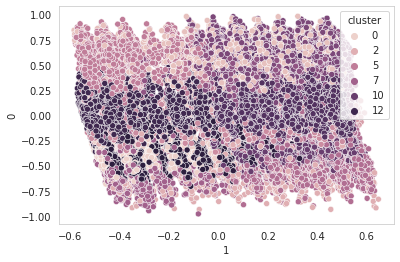

In [373]:
sb.scatterplot(data=X, x=1, y=0, hue="cluster")

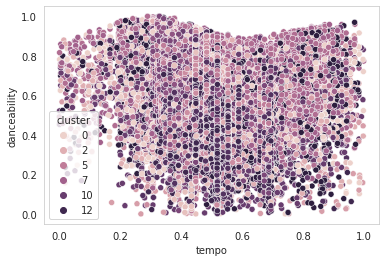

In [374]:
sb.scatterplot(data=data, x='tempo', y='danceability', hue="cluster")

In [375]:
data.drop(columns='cluster',inplace=True)

In [376]:
data.head()

danceability    energy       key  ...     tempo  duration_ms  genre
index                                    ...                              
0          0.807362  0.762452  0.181818  ...  0.568318     0.148589    0.0
1          0.669939  0.352490  0.727273  ...  0.272963     0.342779    0.0
2          0.830675  0.863346  0.454545  ...  0.998717     0.098592    0.0
3          0.371779  0.720307  0.000000  ...  0.779504     0.146882    0.0
4          0.766871  0.519796  0.181818  ...  0.504906     0.146177    0.0

[5 rows x 12 columns]

# hierarchical clustering

In [377]:
data.head()

danceability    energy       key  ...     tempo  duration_ms  genre
index                                    ...                              
0          0.807362  0.762452  0.181818  ...  0.568318     0.148589    0.0
1          0.669939  0.352490  0.727273  ...  0.272963     0.342779    0.0
2          0.830675  0.863346  0.454545  ...  0.998717     0.098592    0.0
3          0.371779  0.720307  0.000000  ...  0.779504     0.146882    0.0
4          0.766871  0.519796  0.181818  ...  0.504906     0.146177    0.0

[5 rows x 12 columns]

In [378]:
pca = PCA(n_components = 3)
X = pca.fit_transform(data)
X=pd.DataFrame(X)
X.head()

0         1         2
0 -0.693851 -0.233400  0.124018
1 -0.561621  0.293738  0.517798
2 -0.447019 -0.023683 -0.032075
3 -0.505145 -0.463227  0.063378
4 -0.782531 -0.206600  0.277723

In [317]:
# import scipy.cluster.hierarchy as shc
# plt.figure(figsize=(10, 7))  
# plt.title("Dendrograms")  
# dend = shc.dendrogram(shc.linkage(X, method='single'))

In [386]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='single')  
cluster.fit_predict(data)

array([0, 0, 0, ..., 0, 0, 0])

In [387]:
from sklearn import metrics
print(metrics.silhouette_score(data, cluster.labels_))

0.28256180080445


In [388]:
pca = PCA(n_components = 2)
X = pca.fit_transform(data)
X=pd.DataFrame(X)
X.head()

0         1
0 -0.693851 -0.233400
1 -0.561621  0.293738
2 -0.447019 -0.023683
3 -0.505145 -0.463227
4 -0.782531 -0.206600

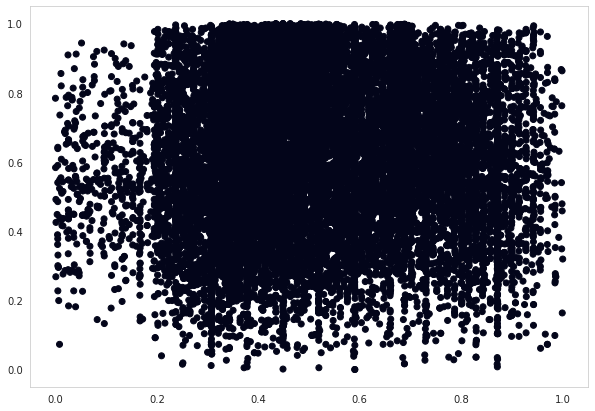

In [389]:
plt.figure(figsize=(10, 7))  
plt.scatter(data['tempo'], data['energy'], c=cluster.labels_) 

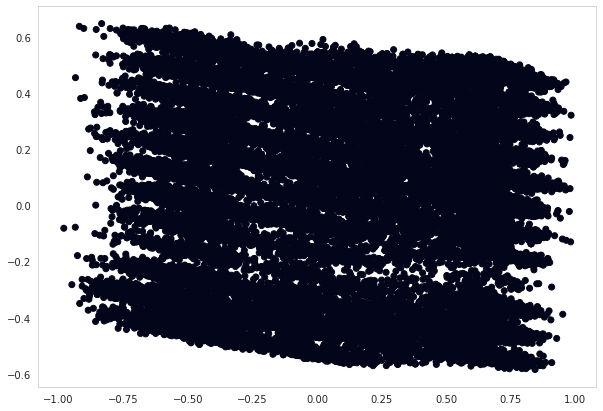

In [390]:
plt.figure(figsize=(10, 7))  
plt.scatter(X[0], X[1], c=cluster.labels_) 

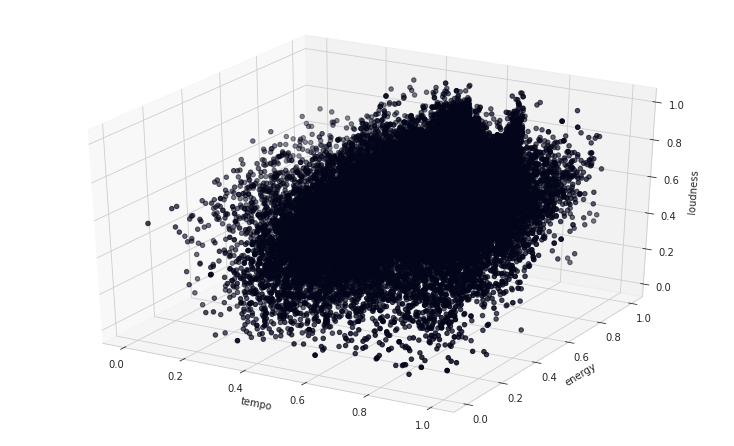

In [391]:
sb.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(10,6))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2

x = data['tempo']
y = data['energy']
z = data['loudness']


ax.scatter(x, y, z, c=cluster.labels_, marker='o')
ax.set_xlabel('tempo')
ax.set_ylabel('energy')
ax.set_zlabel('loudness')

plt.show()

In [393]:
pca = PCA(n_components = 3)
X = pca.fit_transform(data)
X=pd.DataFrame(X)

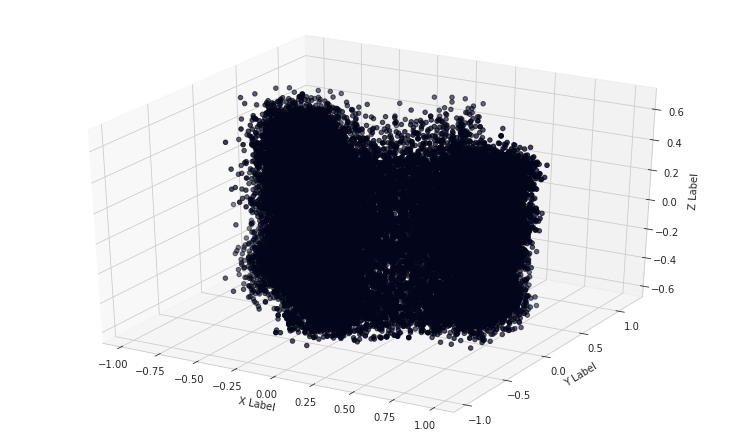

In [394]:
sb.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(10,6))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2

x = X[0]
y = X[2]
z = X[1]


ax.scatter(x, y, z, c=cluster.labels_, marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

# DBSCAN

In [397]:
data.head()

danceability    energy       key  ...     tempo  duration_ms  genre
index                                    ...                              
0          0.807362  0.762452  0.181818  ...  0.568318     0.148589    0.0
1          0.669939  0.352490  0.727273  ...  0.272963     0.342779    0.0
2          0.830675  0.863346  0.454545  ...  0.998717     0.098592    0.0
3          0.371779  0.720307  0.000000  ...  0.779504     0.146882    0.0
4          0.766871  0.519796  0.181818  ...  0.504906     0.146177    0.0

[5 rows x 12 columns]

In [407]:
cluster = DBSCAN(eps=0.4, min_samples=10).fit(data)
cluster.fit_predict(data)

array([ 0,  0, -1, ...,  0,  0,  0])

In [408]:
from sklearn import metrics
print(metrics.silhouette_score(data, cluster.labels_))

0.10819334008383828


In [409]:
pca = PCA(n_components = 2)
X = pca.fit_transform(data)
X=pd.DataFrame(X)

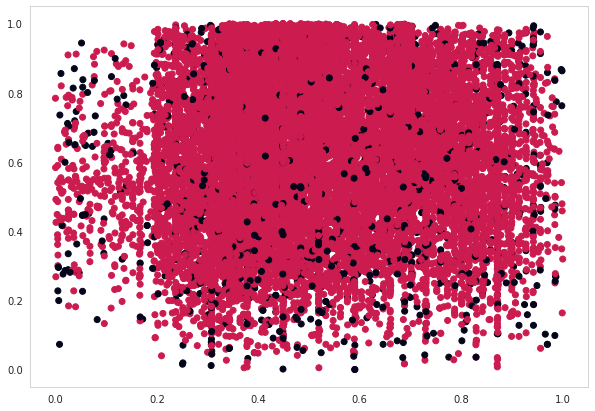

In [410]:
plt.figure(figsize=(10, 7))  
plt.scatter(data['tempo'], data['energy'], c=cluster.labels_) 

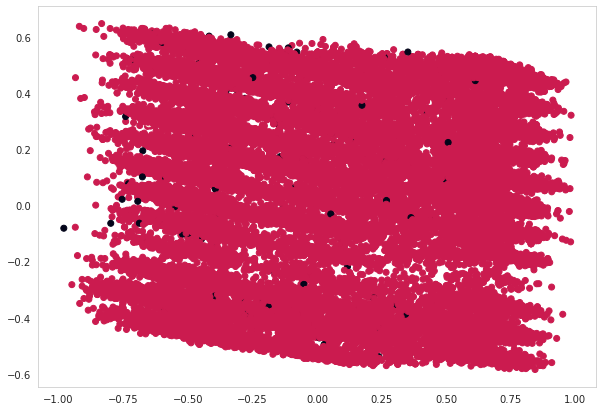

In [400]:
plt.figure(figsize=(10, 7))  
plt.scatter(X[0], X[1], c=cluster.labels_) 

In [412]:
pca = PCA(n_components = 3)
X = pca.fit_transform(data)
X=pd.DataFrame(X)

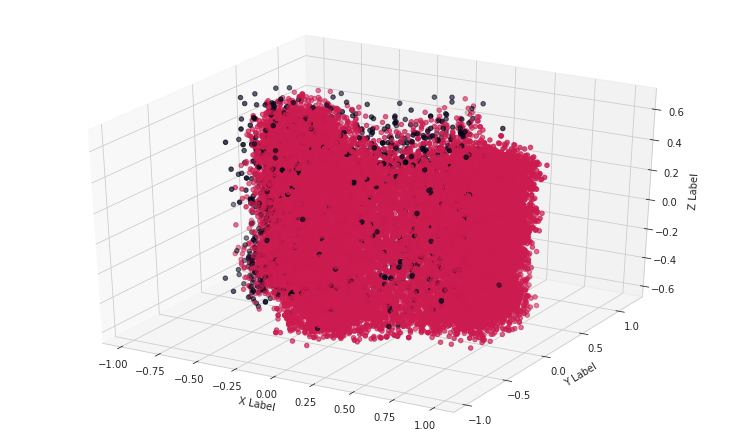

In [413]:
sb.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(10,6))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2

x = X[0]
y = X[2]
z = X[1]


ax.scatter(x, y, z, c=cluster.labels_, marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

# Without_Genre

In [414]:
data = pd.read_csv('/content/drive/MyDrive/genres_v2.csv')
data.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


danceability  energy  ...  Unnamed: 0  title
0         0.831   0.814  ...         NaN    NaN
1         0.719   0.493  ...         NaN    NaN
2         0.850   0.893  ...         NaN    NaN
3         0.476   0.781  ...         NaN    NaN
4         0.798   0.624  ...         NaN    NaN

[5 rows x 22 columns]

In [415]:
frames = [data, mix]
data = pd.concat(frames)
data.head()

danceability  energy  ...  Unnamed: 0  title
0         0.831   0.814  ...         NaN    NaN
1         0.719   0.493  ...         NaN    NaN
2         0.850   0.893  ...         NaN    NaN
3         0.476   0.781  ...         NaN    NaN
4         0.798   0.624  ...         NaN    NaN

[5 rows x 22 columns]

In [416]:
len(data)

42341

In [417]:
genre = data['genre']
genre

0     Dark Trap
1     Dark Trap
2     Dark Trap
3     Dark Trap
4     Dark Trap
        ...    
31          NaN
32          NaN
33          NaN
34          NaN
35          NaN
Name: genre, Length: 42341, dtype: object

In [418]:
data.drop(columns=['song_name' , 'Unnamed: 0' , 'title','type','id','uri','track_href','analysis_url','time_signature','genre','mode'], inplace=True)
data.head()

danceability  energy  key  loudness  ...  liveness  valence    tempo  duration_ms
0         0.831   0.814    2    -7.364  ...    0.0556   0.3890  156.985       124539
1         0.719   0.493    8    -7.230  ...    0.1180   0.1240  115.080       224427
2         0.850   0.893    5    -4.783  ...    0.3720   0.0391  218.050        98821
3         0.476   0.781    0    -4.710  ...    0.1140   0.1750  186.948       123661
4         0.798   0.624    2    -7.668  ...    0.1660   0.5910  147.988       123298

[5 rows x 11 columns]

In [419]:
# for col in data.columns :
#   if data[col].dtype == 'int64' or data[col].dtype == 'float64':
#     up = data[col].mean() + 3*data[col].std()
#     low = data[col].mean() - 3*data[col].std()
#     mask = (data[col] > up ) | (data[col] < low )
#     data = data.drop(data[mask].index)

In [420]:
# data['index'] = list(range(len(data)))
# data.set_index(data['index'], inplace = True)
# data.drop(columns='index',inplace=True)

In [421]:
len(data)

42341

In [422]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data)
data_scaled

array([[0.82988406, 0.81395479, 0.18181818, ..., 0.38202827, 0.61000598,
        0.10370236],
       [0.70852747, 0.49287677, 0.72727273, ..., 0.1086351 , 0.35184786,
        0.20839941],
       [0.85047134, 0.89297399, 0.45454545, ..., 0.02104612, 0.98620035,
        0.07674618],
       ...,
       [0.5243255 , 0.42586048, 0.63636364, ..., 0.23862581, 0.55324877,
        0.28819569],
       [0.45281179, 0.75293996, 0.09090909, ..., 0.41401011, 0.35198339,
        0.24683067],
       [0.29136418, 0.9859966 , 0.36363636, ..., 0.47591045, 0.41091527,
        0.4723641 ]])

In [423]:
data = pd.DataFrame(data_scaled,index= data.index,columns=data.columns)
data.head()

danceability    energy       key  ...   valence     tempo  duration_ms
0      0.829884  0.813955  0.181818  ...  0.382028  0.610006     0.103702
1      0.708527  0.492877  0.727273  ...  0.108635  0.351848     0.208399
2      0.850471  0.892974  0.454545  ...  0.021046  0.986200     0.076746
3      0.445227  0.780947  0.000000  ...  0.161250  0.794595     0.102782
4      0.794127  0.623909  0.181818  ...  0.590426  0.554579     0.102402

[5 rows x 11 columns]

# KMeans

In [424]:
from sklearn import metrics

In [425]:
silhouette_list = []
for k in np.arange(2, 20):
  kmn = KMeans(n_clusters=k)
  kmn.fit(data)
  y_clusters = kmn.fit_predict(data)
  silhouette_list.append(metrics.silhouette_score(data,y_clusters))

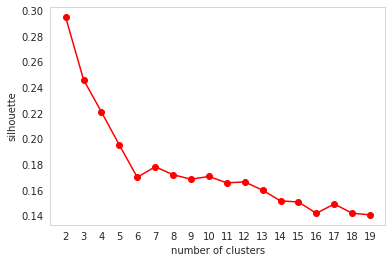

In [426]:
plt.plot(np.arange(2, 20),silhouette_list,'ro-')
plt.xticks(ticks=np.arange(2, 20))
plt.xlabel('number of clusters')
plt.ylabel('silhouette')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


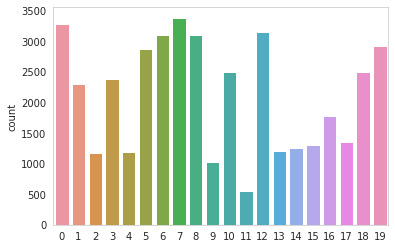

In [427]:
kmn = KMeans(n_clusters = 20, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
y_clusters = kmn.fit_predict(data)
# countplot to check the number of clusters and number of customers in each cluster
sb.countplot(y_clusters)

In [428]:
from sklearn import metrics
print(metrics.silhouette_score(data, y_clusters))

0.14420349810362657


In [429]:
data['cluster'] = y_clusters
data['genre'] = genre
for gen in list(data['genre'].unique()):
  print(f'genre : {gen}')
  print('cluster :',data[data['genre']==gen]['cluster'].unique())
data.drop(columns=['genre','cluster'],inplace=True)

genre : Dark Trap
cluster : [ 8  5 12  6  0  2 14 10  3 11 17 19 15  1  7  4 18 16 13  9]
genre : Underground Rap
cluster : [10  2  0  3  8 14  5 17 12  1 11  6 16 15 19 13 18  9  7  4]
genre : Trap Metal
cluster : [ 0 14  8 17 10  6  2 12  3  5 19  4  7 15 11 16 18  1  9 13]
genre : Emo
cluster : [19  0  6 10 12  3 17  8  2 14  5  9 15 11  4 16 13  1]
genre : Rap
cluster : [ 8  5 10 15  0  3 12 17 19  2 14  6 18  1 11]
genre : RnB
cluster : [10  0 15 19  6 12  3  5  8  2 14 17 11 13  7  1 18]
genre : Pop
cluster : [ 3 10  0 19 17  5  6 12  8 14 15 11  2 13  7 18]
genre : Hiphop
cluster : [10  0  3 17  5 14  8 12  6  2 15 19 11 16 13  1  7 18]
genre : techhouse
cluster : [16  7  3 13  0  1 19 18  4  5  8  2 12 14 11  6  9 15 17]
genre : techno
cluster : [ 4 18  7  1 11 16 12 13  6 19  3  0  5  9  8 14  2]
genre : trance
cluster : [12  1  7 13  6 19 16 18 17  9  4 14  2  5  8  3 15 11  0]
genre : psytrance
cluster : [ 4  1 18  7 16 13  9 12  2  8  6 19  3  5  0]
genre : trap
cluster : [

In [430]:
pca = PCA(n_components = 3)
X = pca.fit_transform(data)
X=pd.DataFrame(X)

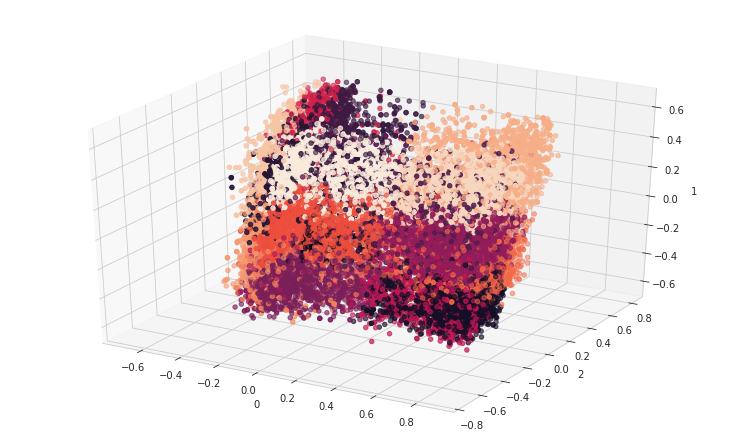

In [431]:
sb.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(10,6))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2

x = X[0]
y = X[2]
z = X[1]


ax.scatter(x, y, z, c=y_clusters, marker='o')
ax.set_xlabel('0')
ax.set_ylabel('2')
ax.set_zlabel('1')

plt.show()

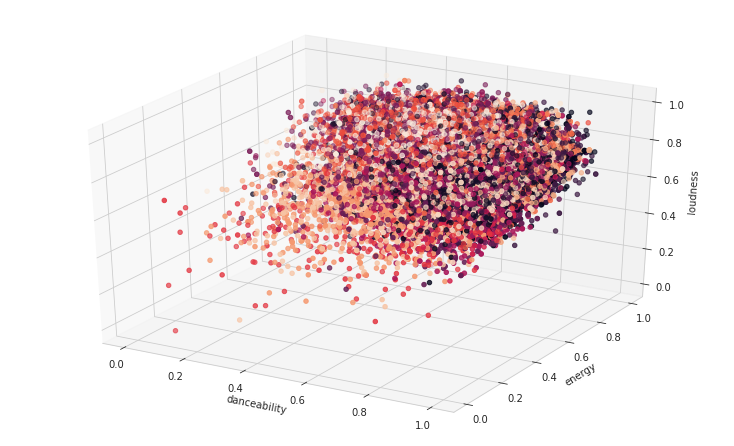

In [432]:
sb.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(10,6))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2

x = data['danceability']
y = data['energy']
z = data['loudness']


ax.scatter(x, y, z, c=y_clusters, marker='o')
ax.set_xlabel('danceability')
ax.set_ylabel('energy')
ax.set_zlabel('loudness')

plt.show()

In [433]:
pca = PCA(n_components = 2)
X = pca.fit_transform(data)
X=pd.DataFrame(X)
X['cluster'] = y_clusters
data['cluster'] = y_clusters

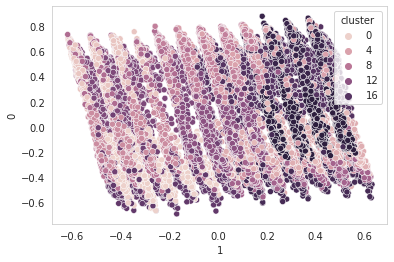

In [434]:
sb.scatterplot(data=X, x=1, y=0, hue="cluster")

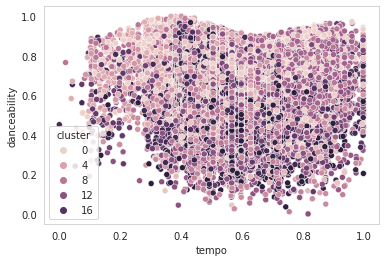

In [435]:
sb.scatterplot(data=data, x='tempo', y='danceability', hue="cluster")

In [436]:
data.iloc[42305]

danceability        0.359627
energy              0.385851
key                 0.000000
loudness            0.628736
speechiness         0.029893
acousticness        0.274291
instrumentalness    0.000000
liveness            0.181418
valence             0.197359
tempo               0.531502
duration_ms         0.345678
cluster             8.000000
Name: 0, dtype: float64

In [437]:
data.drop(columns='cluster',inplace=True)
data.head()

danceability    energy       key  ...   valence     tempo  duration_ms
0      0.829884  0.813955  0.181818  ...  0.382028  0.610006     0.103702
1      0.708527  0.492877  0.727273  ...  0.108635  0.351848     0.208399
2      0.850471  0.892974  0.454545  ...  0.021046  0.986200     0.076746
3      0.445227  0.780947  0.000000  ...  0.161250  0.794595     0.102782
4      0.794127  0.623909  0.181818  ...  0.590426  0.554579     0.102402

[5 rows x 11 columns]

In [438]:
import pickle
pickle.dump(kmn, open("model.pkl", "wb"))

In [439]:
df.to_csv (r'/content/drive/MyDrive/spotify_data/spotify_dataframe.csv', index = False, header=True)

NameError: ignored

In [ ]:
data.iloc[42305:42341].to_csv(r'/content/drive/MyDrive/MyPlayList_dataframe.csv', index = False, header=True)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/genres_v2.csv')
data.head()

In [ ]:
len(data)

In [ ]:
len(y_clusters)

In [ ]:
len(y_clusters[:42305])

In [ ]:
data['cluster'] = y_clusters[:42305]

In [ ]:
data.to_csv(r'/content/drive/MyDrive/AllMusic_dataframe.csv', index = False, header=True)

# DBSCAN

In [ ]:
from sklearn import metrics

In [ ]:
pca = PCA(n_components = 7)
X = pca.fit_transform(data)
X=pd.DataFrame(X)

In [ ]:
epses = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
min_sampleses = [5,10,15,20,25,30,35,40,45,50]

In [ ]:
# silhouette_list = []
# for i in epses:
#   for j in min_sampleses:
#     cluster = DBSCAN(eps=i, min_samples=j).fit(data)
#     if len(pd.DataFrame(cluster.labels_).value_counts().unique()) !=1:
#       print('eps: ',i,' min sample: ',j,'silhouette is : ', metrics.silhouette_score(X, cluster.labels_))
#     else:
#       print('eps: ',i,' min sample: ',j,' one cluster')

eps:  0.1  min sample:  5 silhouette is :  -0.6945728151873399
eps:  0.1  min sample:  10 silhouette is :  0.026540925805139663
eps:  0.1  min sample:  15  one cluster
eps:  0.1  min sample:  20  one cluster
eps:  0.1  min sample:  25  one cluster
eps:  0.1  min sample:  30  one cluster
eps:  0.1  min sample:  35  one cluster
eps:  0.1  min sample:  40  one cluster
eps:  0.1  min sample:  45  one cluster
eps:  0.1  min sample:  50  one cluster
eps:  0.15  min sample:  5 silhouette is :  -0.6701889934407417
eps:  0.15  min sample:  10 silhouette is :  -0.41166106716228207
eps:  0.15  min sample:  15 silhouette is :  -0.20178056156041946
eps:  0.15  min sample:  20 silhouette is :  -0.17685506200554546
eps:  0.15  min sample:  25 silhouette is :  -0.16189944189012
eps:  0.15  min sample:  30 silhouette is :  -0.01198491466128819
eps:  0.15  min sample:  35 silhouette is :  9.171076900377995e-06
eps:  0.15  min sample:  40  one cluster
eps:  0.15  min sample:  45  one cluster
eps:  0.15  

In [ ]:
cluster = DBSCAN(eps=0.4, min_samples=5).fit(data)
pd.DataFrame(cluster.labels_).value_counts()

 0    38376
-1      519
 1        5
 2        3
dtype: int64

In [ ]:
from sklearn import metrics
print(metrics.silhouette_score(data, cluster.labels_))

0.0968265122366697


In [ ]:
cluster = DBSCAN(eps=0.25, min_samples=10).fit(data)
pd.DataFrame(cluster.labels_).value_counts()

 0     23360
-1     15087
 17       42
 2        35
 8        18
 24       16
 3        14
 4        14
 7        14
 5        13
 14       13
 40       13
 33       12
 30       12
 6        11
 10       11
 11       11
 31       11
 28       10
 12       10
 38       10
 1        10
 29       10
 20       10
 32       10
 9        10
 27       10
 34        9
 13        9
 39        9
 19        9
 18        8
 35        8
 15        7
 16        7
 23        7
 26        7
 21        6
 37        6
 22        5
 25        5
 36        4
dtype: int64

In [ ]:
from sklearn import metrics
print(metrics.silhouette_score(data, cluster.labels_))

-0.39731914530018075


In [ ]:
pca = PCA(n_components = 2)
X = pca.fit_transform(data)
X=pd.DataFrame(X)

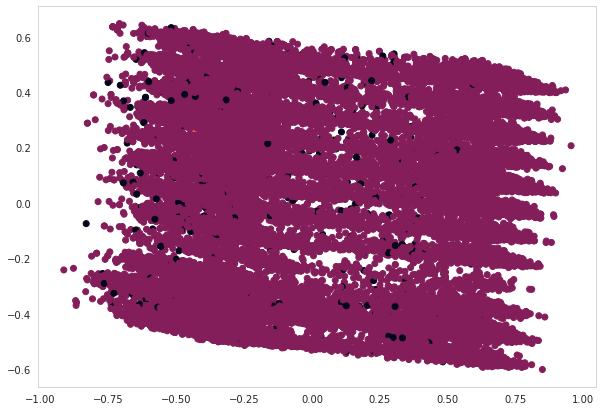

In [ ]:
plt.figure(figsize=(10, 7))  
plt.scatter(X[0], X[1], c=cluster.labels_) 

In [ ]:
pca = PCA(n_components = 3)
X = pca.fit_transform(data)
X=pd.DataFrame(X)

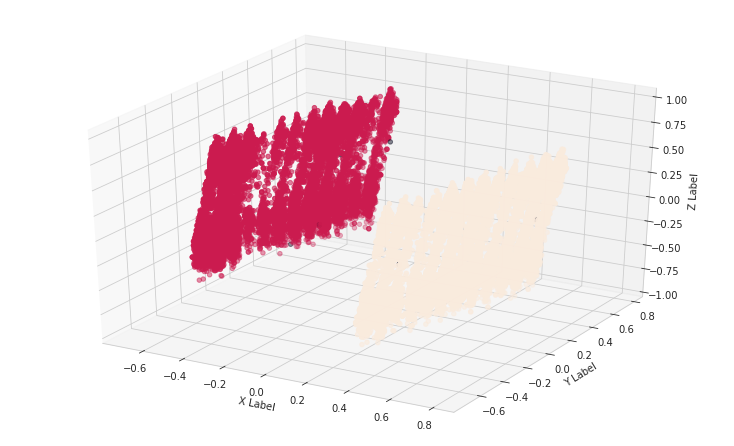

In [ ]:
sb.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(10,6))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2

x = X[0]
y = X[2]
z = X[1]


ax.scatter(x, y, z, c=cluster.labels_, marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()